### Training

In [7]:
import numpy as np
import os
import subprocess
import cv2
import re

In [5]:
def split_img(img, offset=256, tile_size=512, names=False):
    if offset:
        img = img[offset:-offset, offset:-offset]
    imgs = []
    names_list = []
    for i in range(0, img.shape[0], tile_size):
        for j in range(0, img.shape[1], tile_size):
            imgs.append(img[i:i+tile_size, j:j+tile_size])
            names_list.append("Y{}_X{}".format(i//tile_size, j//tile_size))
    return (imgs, names_list) if names else imgs

In [13]:
#Split a folder of larger images into smaller images  
folder = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_full/s250-259/segmentations"
folder_split = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
if os.path.exists(folder_split):
    subprocess.run(f"rm -f {folder_split}/*", shell=True)
else:
    os.makedirs(folder_split)
    
imgs = os.listdir(folder)
for img in imgs:
    read_img = cv2.imread(f"{folder}/{img}", cv2.IMREAD_GRAYSCALE)
    split_imgs = split_img(read_img, offset=0, tile_size=512)
    for i, split in enumerate(split_imgs):
        cv2.imwrite(f"{folder_split}/{re.sub(r'.png$', r'', img)}_part{i+1}.png", split)


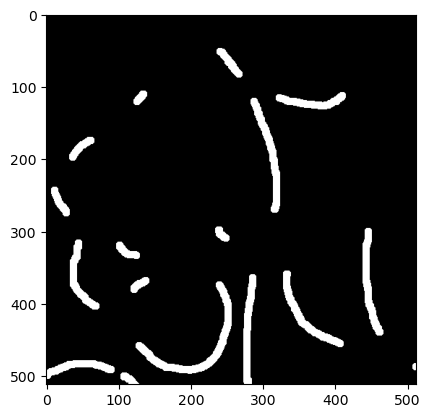

In [16]:
import matplotlib.pyplot as plt
a = cv2.imread("/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts/SEM_adult_image_export_s200_part1_label.png", cv2.IMREAD_GRAYSCALE)
#a = a*255
a[a != 0] = 255
plt.imshow(a, cmap='gray')

In [3]:
import numpy as np
from scipy.ndimage import label

def filter_pixels(img) -> np.ndarray:
    """
    Changes all non-zero pixel islands in an image to zero if they are less than 8 pixels in size. Designed for greyscale images.
    """
    # Create a copy to avoid modifying the original during iteration
    filtered = img.copy()
    # Label connected components (8-connectivity)
    structure = np.ones((3, 3), dtype=int)
    labeled, num_features = label(img > 0, structure=structure)
    # For each pixel, check if its component has at least 8 pixels
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] != 0:
                component_label = labeled[y, x]
                if component_label == 0:
                    filtered[y, x] = 0
                    continue
                # Count pixels in this component
                count = np.sum(labeled == component_label)
                if count < 8:
                    filtered[y, x] = 0
    return filtered

In [ ]:
#Test filter_pixels function
a = np.zeros((512, 512), dtype=np.uint8)

#Case 1: One non-zero pixel
a[100, 100] = 255
print("Case 1: One non-zero pixel")
print(f"Image is non-zero: {np.any(a != 0)}")
a = filter_pixels(a)
print(f"After filtering, image is non-zero: {np.any(a != 0)} \n")

#Case 2: 8 pixels in a line
a[0:8, 100] = 255
print("Case 2: 8 pixels in a line")
print(f"Image is non-zero: {np.any(a != 0)}")
a = filter_pixels(a)
print(f"After filtering, image is non-zero: {np.any(a != 0)}")

Case 1: One non-zero pixel
Image is non-zero: True
After filtering, image is non-zero: False 

Case 2: 8 pixels in a line
Image is non-zero: True
After filtering, image is non-zero: True


In [7]:
#Check if all images are 512x512
from pathlib import Path
count = 0
root_folder = "/home/tommytang111/data/sem_adult/SEM_split/s250-259"

for folder in os.listdir(root_folder):
    for img in os.listdir(Path(root_folder) / folder):
        read_img = cv2.imread(Path(root_folder) / folder / img, cv2.IMREAD_GRAYSCALE)
        count += 1 if read_img.shape != (512, 512) else 0

count
        

0

In [12]:
#Training on sections 250-259 and validating on sections 200-209 
!python3 unet.py \
--dataset new \
--batch_size 8 \
--focal \
--epochs 100 \
--model_name 2d_gd_mem_run1_model5_epoch149.pk1

ARGS:  ['unet.py', '--dataset', 'new', '--batch_size', '8', '--focal', '--epochs', '100', '--model_name', '2d_gd_mem_run1_model5_epoch149.pk1']
Data loaders created.
Current dataset new
wandb: Currently logged in as: tommytang111 (tommytang111-lunenfeld-tanenbaum-research-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.10
wandb: Run data is saved locally in /home/tommytang111/wandb/wandb/run-20250523_171226-joorrbte
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hardy-serenity-4
wandb: ⭐️ View project at https://wandb.ai/tommytang111-lunenfeld-tanenbaum-research-institute/gap-junction-segmentation
wandb: 🚀 View run at https://wandb.ai/tommytang111-lunenfeld-tanenbaum-research-institute/gap-junction-segmentation/runs/joorrbte
Starting training...
SAVING MODELS TO /home/tommytang111/modelsfocal0
running for 100 epochs
Using device: cuda
100%|█| 5/5 [00:06<00:00,  1.13it/s, loss=Loss: 0.261559